In [1]:
# Improt the necessary libraries
import itertools
import xarray as xr
import rasterio
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import numpy as np
from ai4ebv.core import landcover

In [2]:
# Filepaths

WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"
WTE_GLOBAL = "WTE1778_global.tif"

# Wte table

WTE_TABLE = WTE_FOLDER + "Tables/Realm_WE_attribute_Table_DraftSort.csv"

# Himalayas 4 tiles shapefile

HIMALAYA_SHP = "/mnt/drive/AI4EBV/BOUNDARIES/Himalayas_4_tiles.shp"

OUTPUT_CRS = "EPSG:32645"

Read the input WTE layer

In [3]:
wte_global = xr.open_rasterio(WTE_FOLDER + WTE_GLOBAL)
wte_global

<xarray.DataArray (band: 1, y: 62171, x: 160299)>
[9965949129 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 83.62 83.62 83.62 83.62 ... -55.99 -55.99 -56.0 -56.0
  * x        (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0 180.0
Attributes:
    transform:      (0.002245799, 0.0, -179.999999, 0.0, -0.002245799, 83.624...
    crs:            +init=epsg:4326
    res:            (0.002245799, 0.002245799)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('Band Math (fix(b1))',)
    AREA_OR_POINT:  Area
    Band_1:         Band Math (fix(b1))

Read the input shapefile

In [4]:
df = gpd.read_file(HIMALAYA_SHP)
df[df.index==0].geometry

0    POLYGON Z ((84.94795 28.91264 0.00000, 86.0739...
Name: geometry, dtype: geometry

In [5]:
df_merged = df.dissolve().explode()
df_merged.geometry.bounds

,,minx,miny,maxx,maxy
0,0,84.947953,27.019727,87.100136,28.928245


In [6]:
minX = df_merged.geometry.bounds['minx']
minY = df_merged.geometry.bounds['miny']
maxX = df_merged.geometry.bounds['maxx']
maxY = df_merged.geometry.bounds['maxy']

In [7]:
wte_table = pd.read_csv(WTE_TABLE, sep=';')
wte_table

,RealmWE_ID,WE_ID,Realm_ID,RealmClass,LF_Class,MoistClass,TempClass,LC_Class,Realm_Name,LF_Name,LC_Name,Temp_Name,Moist_Name,Temp_Moist,WEcosystm,RWEcosystm,LandC_Type,Code
0,1005,5,1000,1,1,3,6,6,Afrotropic,Mountains,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Mount...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6316
1,1010,10,1000,1,3,3,6,6,Afrotropic,Tablelands,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Table...,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6336
2,1016,16,1000,1,2,3,6,6,Afrotropic,Hills,Sparsley or Non vegetated,Polar,Moist,Polar Moist,Polar Moist Sparsley or Non vegetated on Hills,Afrotropic Polar Moist Sparsley or Non vegetat...,Natural,6326
3,1018,18,1000,1,1,3,6,4,Afrotropic,Mountains,Grassland,Polar,Moist,Polar Moist,Polar Moist Grassland on Mountains,Afrotropic Polar Moist Grassland on Mountains,Natural,6314
4,1024,24,1000,1,3,3,6,2,Afrotropic,Tablelands,Shrubland,Polar,Moist,Polar Moist,Polar Moist Shrubland on Tablelands,Afrotropic Polar Moist Shrubland on Tablelands,Natural,6332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,8399,399,8000,8,1,3,3,8,Palearctic,Mountains,Snow and Ice,Warm Temperate,Moist,Warm Temperate Moist,Warm Temperate Moist Snow and Ice on Mountains,Palearctic Warm Temperate Moist Snow and Ice o...,Natural,3318
1777,8400,400,8000,8,3,1,4,3,Palearctic,Tablelands,Forest,Sub Tropical,Desert,Sub Tropical Desert,Sub Tropical Desert Forest on Tablelands,Palearctic Sub Tropical Desert Forest on Table...,Natural,4133
1778,8406,406,8000,8,2,1,5,3,Palearctic,Hills,Forest,Tropical,Desert,Tropical Desert,Tropical Desert Forest on Hills,Palearctic Tropical Desert Forest on Hills,Natural,5123
1779,8412,412,8000,8,3,1,5,2,Palearctic,Tablelands,Shrubland,Tropical,Desert,Tropical Desert,Tropical Desert Shrubland on Tablelands,Palearctic Tropical Desert Shrubland on Tablel...,Natural,5132


# Landcover

## WTE Landcover Layer

In [9]:
wte_clipped = wte_global.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY)
max_value = wte_clipped.max().values
while(max_value>8):
    LFValue = wte_table.loc[wte_table['RealmWE_ID']==max_value]['LC_Class']
    if len(LFValue) != 0:
        wte_clipped = wte_clipped.where(wte_clipped!=max_value).fillna(int(LFValue))
    else:
        break
    max_value = wte_clipped.max().values
wte_clipped = wte_clipped.where(wte_clipped!=wte_clipped.attrs["_FillValue"])
wte_clipped.attrs["_FillValue"] = np.nan

Define colors and labels for plotting:

In [10]:
landcover_colors = {'Cropland':"#FFFF64",'Shrubland':"#966400",'Forest':"#00A000",'Grassland':"#FFB432",'Settlement':"#C31400",'Bare Areas':"#FFEBAF",'Surface Water':"#BEE8FF",'Snow and Ice':"#FFFFFF"}
landcovers     = ['Cropland','Shrubland','Forest','Grassland','Settlement','Bare Areas','Surface Water','Snow and Ice']

legend = []
for i,x in enumerate(landcovers):
    color = landcover_colors[x]
    legend.append(mpatches.Patch(color=color,label=x))

Create cmap for landcover layer

In [11]:
cmap_landcover = ListedColormap(["#FFFF64","#966400","#00A000","#FFB432","#C31400","#FFEBAF","#BEE8FF","#FFFFFF"])

Reproject to the desired UTM projection:

In [12]:
wte_lc_UTM = wte_clipped.rio.reproject(OUTPUT_CRS,resolution=250, resampling=6) # Majority - Mode
# wte_lc_UTM = wte_clipped.rio.reproject(wte_clipped.rio.estimate_utm_crs(),resolution=250, resampling=6) # New Proj required

[]

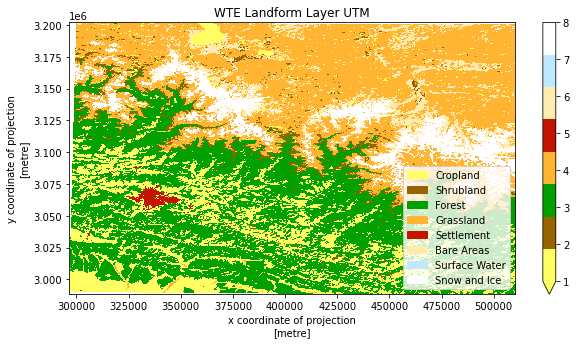

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
fig = wte_lc_UTM[0].plot.imshow(ax=ax,cmap=cmap_landcover,vmax=8, vmin=1)
ax.set_title("WTE Landform Layer UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [14]:
# wte_lc_UTM[0].to_netcdf("wte_lc_UTM_Himalaya.nc")

## Copernicus Global Land cover

In [15]:
LANDCOVER_FOLDER = "/mnt/drive/AI4EBV/INPUTS/LANDCOVER/"
WTE_FOLDER = "/mnt/drive/AI4EBV/INPUTS/WTE/"

CGLC   = LANDCOVER_FOLDER + "COPERNICUS_GLOBAL_LC/E080N40_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif"

In [16]:
cglc_landcover = xr.open_rasterio(CGLC)
cglc_landcover

<xarray.DataArray (band: 1, y: 20160, x: 20160)>
[406425600 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 40.0 40.0 40.0 40.0 40.0 ... 20.0 20.0 20.0 20.0 20.0
  * x        (x) float64 80.0 80.0 80.0 80.0 80.0 ... 100.0 100.0 100.0 100.0
Attributes: (12/36)
    transform:                    (0.0009920634920634888, 0.0, 80.0, 0.0, -0....
    crs:                          +init=epsg:4326
    res:                          (0.0009920634920634888, 0.0009920634920634888)
    is_tiled:                     1
    nodatavals:                   (255.0,)
    scales:                       (1.0,)
    ...                           ...
    sensor:                       VEGETATION
    source:                       Derived from EO satellite imagery
    time_coverage_end:            2016-12-31T23:59:59Z
    time_coverage_start:          2014-01-01T00:00:00Z
    time_reference_year:          2015
    title:                        Dynamic Land Cover Map 100m 2015-base

In [17]:
cglc_landcover_clipped = cglc_landcover.rio.clip_box(minx=minX,miny=minY,maxx=maxX,maxy=maxY).astype(float)
cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=cglc_landcover_clipped.attrs["_FillValue"])
cglc_landcover_clipped.attrs["_FillValue"] = np.nan

Classify CGIC Landcover to WTE scheme

In [18]:
# Create a NaN mask
na_mask = np.bitwise_not(xr.ufuncs.isnan(cglc_landcover_clipped))
max_value = int(cglc_landcover_clipped.max().values)
while(max_value>8):
    if max_value==255:
        lcValue = np.nan
        cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=max_value).fillna(lcValue)
        max_value = int(cglc_landcover_clipped.max().values)
    elif max_value!=255:
        try:
            lcValue = landcover.Copernicus2Wte[max_value]
        except:
            lcValue = 255
        cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=max_value).fillna(lcValue)
        max_value = int(cglc_landcover_clipped.max().values)
    else:
        break

cglc_landcover_clipped = cglc_landcover_clipped.where(na_mask)

Reprojection to 250m in UTM with mode interpolation

In [19]:
cglc_landcover_clipped = cglc_landcover_clipped.rio.reproject_match(wte_lc_UTM,6)
cglc_landcover_clipped = cglc_landcover_clipped.where(cglc_landcover_clipped!=cglc_landcover_clipped.attrs["_FillValue"])
cglc_landcover_clipped.attrs["_FillValue"] = np.nan

[]

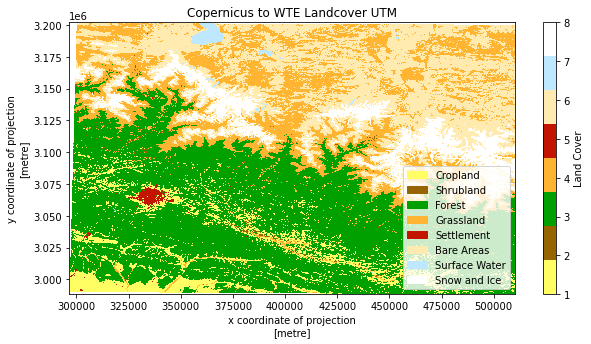

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
fig = cglc_landcover_clipped[0].plot.imshow(ax=ax,cmap=cmap_landcover,vmax=8, vmin=1)
ax.set_title("Copernicus to WTE Landcover UTM")
ax.legend(handles=legend,loc='lower right')
ax.margins(10)
plt.plot()

In [21]:
# cglc_landcover_clipped[0].to_netcdf("cglc_lc_UTM_Himalaya.nc")

Combine the NaN masks and mask the data to avoid not overlapping pixels due to reprojection:

In [22]:
na_mask = np.bitwise_not(np.bitwise_or(xr.ufuncs.isnan(wte_lc_UTM),xr.ufuncs.isnan(cglc_landcover_clipped)))
wte_lc_UTM_masked_cglc = wte_lc_UTM.where(na_mask)
cglc_to_wte_UTM_masked = cglc_landcover_clipped.where(na_mask)

Now that we have both moisture layers with the same class scheme and projection we can compute the difference:

In [23]:
wte_cglc_diff = wte_lc_UTM_masked_cglc - cglc_to_wte_UTM_masked

[]

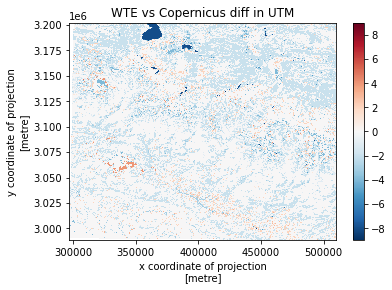

In [24]:
fig, ax = plt.subplots()
wte_cglc_diff[0].plot.imshow(ax=ax)
ax.set_title("WTE vs Copernicus diff in UTM")
plt.plot()

Table resuming the correspondence between the data
1. Compute the number of pixels which are non zero
2. Compute the percentage and the area in km^2 of the difference

In [25]:
#WTE vs CGLC:
wte_cglc_diff_km2 = np.count_nonzero(wte_cglc_diff.fillna(0).astype(np.int8)) * (0.25**2) #Area in km^2
wte_cglc_diff_dis = np.count_nonzero(wte_cglc_diff.fillna(0))/np.count_nonzero(~np.isnan(wte_cglc_diff))*100 #Percentage of disagreement

In [26]:
import pandas as pd

data = {'Disagreement [km^2]':  [wte_cglc_diff_km2],
        'Disagreement [%]': [wte_cglc_diff_dis],
        }

df = pd.DataFrame(data, columns = ['Disagreement [km^2]','Disagreement [%]'], index=['WTE vs CGLC'])

df

,Disagreement [km^2],Disagreement [%]
WTE vs CGLC,16865.0625,37.659887


In [27]:
def plot_confusion_matrix(ax, cm, labels, normalize=True, cmap='Blues',true="WTE",predicted="predicted"):
    """Plot the confusion matrix ``cm``.
    Parameters
    ----------
    cm : :py:class:`numpy.ndarray`
        The confusion matrix.
    labels : `list` [`str`]
        Names of the classes.
    normalize : `bool`, optional
        Whether to normalize the confusion matrix. The default is `True`.
    figsize : `tuple` [`int`], optional
        The figure size in centimeters. The default is `(10, 10)`.
    cmap : `str`, optional
        A matplotlib colormap. The default is `'Blues'`.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        An instance of :py:class:`matplotlib.figure.Figure`.
    ax : :py:class:`matplotlib.axes._subplots.AxesSubplot`
        An instance of :py:class:`matplotlib.axes._subplots.AxesSubplot`.
    """
    # number of classes
    nclasses = len(labels)

    # string format to plot values of confusion matrix
    fmt = '.0f'

    # minimum and maximum values of the colorbar
    vmin, vmax = 0, cm.max()

    # check whether to normalize the confusion matrix
    if normalize:
        # normalize
        norm = cm.sum(axis=1, keepdims=True)

        # check for division by zero
        norm[norm == 0] = 1
        cm = cm / norm

        # change string format to floating point
        fmt = '.2f'
        vmin, vmax = 0, 1

    # get colormap
    cmap = colormap.get_cmap(cmap, 256)

    # plot confusion matrix
    im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)

    # threshold determining the color of the values
    thresh = (cm.max() + cm.min()) / 2

    # brightest/darkest color of current colormap
    cmap_min, cmap_max = cmap(0), cmap(256)

    # plot values of confusion matrix
    for i, j in itertools.product(range(nclasses), range(nclasses)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=cmap_max if cm[i, j] < thresh else cmap_min)

    # axes properties and labels
    ax.set(xticks=np.arange(nclasses),yticks=np.arange(nclasses),xticklabels=labels,yticklabels=labels,ylabel=true,xlabel=predicted)

    # rotate x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    return


Define colors and labels for plotting:

In [33]:
colors_diff = ["#E0E0E0","#FFAA00"]
labels_diff = ["same","different"]
legend_diff = []
for i,x in enumerate(labels_diff):
    legend_diff.append(mpatches.Patch(color=colors_diff[i],label=x))

Create cmap for difference layer

In [34]:
diff_cmap = ListedColormap(["#E0E0E0","#FFAA00"])

[]

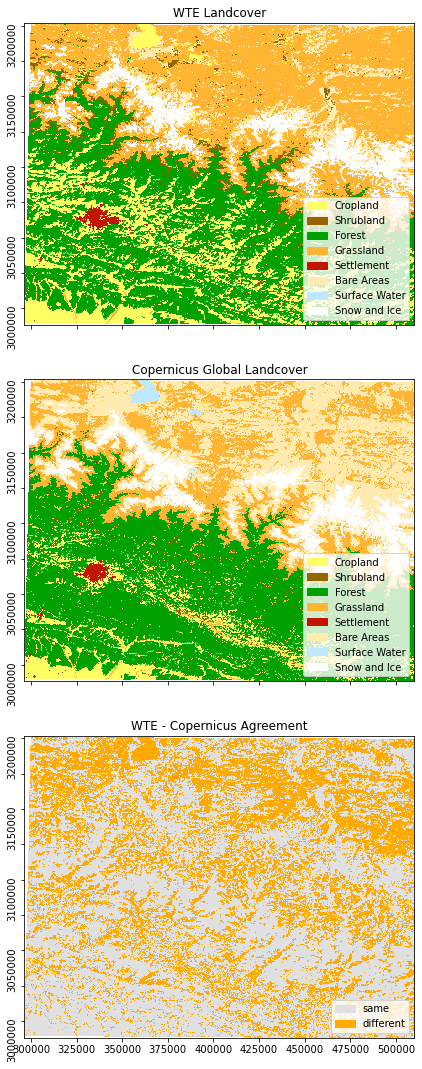

In [66]:
landcover_labels     = ['Cropland','Shrubland','Forest','Grassland','Settlement','Bare Areas','Surface Water','Snow and Ice']

fig, ax = plt.subplots(3,1,figsize=(6,15),gridspec_kw={'height_ratios': [1,1,1],'width_ratios': [1]})
fig = wte_lc_UTM_masked_cglc[0].plot.imshow(ax=ax[0],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[0].set_title("WTE Landcover")
ax[0].legend(handles=legend,loc='lower right')

fig = cglc_to_wte_UTM_masked[0].plot.imshow(ax=ax[1],cmap=cmap_landcover,vmax=8, vmin=1,add_colorbar=False)
ax[1].set_title("Copernicus Global Landcover")
ax[1].legend(handles=legend,loc='lower right')

na_mask = np.bitwise_not(xr.ufuncs.isnan(wte_cglc_diff[0]))
wte_cglc_diff_masked = (abs(wte_cglc_diff[0])>0)
wte_cglc_diff_masked = wte_cglc_diff_masked.where(na_mask)

fig = wte_cglc_diff_masked.plot.imshow(ax=ax[2],cmap=diff_cmap,add_colorbar=False)#,cmap=diff_cmap,vmax=3, vmin=-3,add_colorbar=False)
ax[2].set_title("WTE - Copernicus Agreement")
ax[2].legend(handles=legend_diff,loc='lower right')

        
# rotate y-tick labels
for k in ax:
    for label in k.get_yticklabels():
        label.set_rotation(90)
    
# remove all axis labels
for k in ax:
    k.set_xlabel("")
    k.set_ylabel("")  
    k.ticklabel_format(style='plain')
        
for k in ax[:2]:
    for i, tick in enumerate(k.xaxis.get_ticklabels()):
        tick.set_visible(False)
        
for k in ax:
    for i, tick in enumerate(k.yaxis.get_ticklabels()):
        if i%2==0:
            tick.set_visible(False)

plt.tight_layout()
plt.plot()

[]

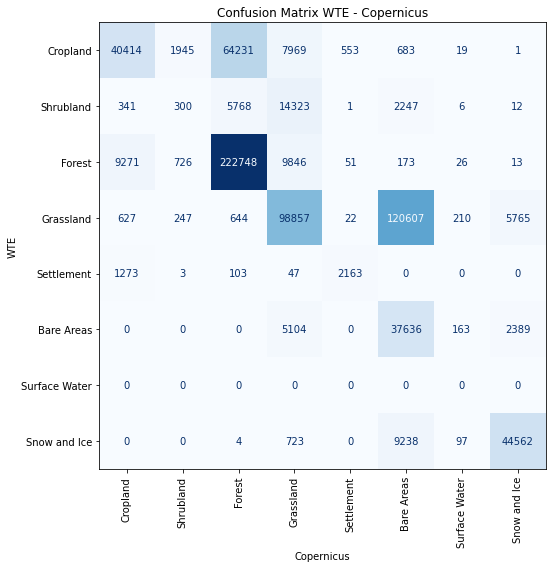

In [43]:
landcover_labels     = ['Cropland','Shrubland','Forest','Grassland','Settlement','Bare Areas','Surface Water','Snow and Ice']

fig, ax = plt.subplots(1,1,figsize=(8,8))

cm_cglc = confusion_matrix(wte_lc_UTM_masked_cglc[0].fillna(-999).values.flatten(), cglc_to_wte_UTM_masked[0].fillna(-999).values.flatten(), labels=[-999,1,2,3,4,5,6,7,8])
cm_cglc = cm_cglc[1:,1:]
plot_confusion_matrix(ax,cm_cglc,[1,2,3,4,5,6,7,8],true="WTE",predicted="Copernicus", normalize=None)
ax.set_xticklabels(landcover_labels)
ax.set_yticklabels(landcover_labels)
ax.set_title("Confusion Matrix WTE - Copernicus")

plt.tight_layout()
plt.plot()

In [67]:
diagonal = 0
wrong = 0
for i in range(cm_cglc.shape[0]):
    for j in range(cm_cglc.shape[1]):
        if i==j:
            diagonal += cm_cglc[i,j]
        else:
            wrong += cm_cglc[i,j]
print("Disagreement %: ",wrong/(diagonal+wrong)*100)
print("Disagreement km^2: ",wrong*0.25*0.25)

Disagreement %:  0.3727734707948174
Disagreement km^2:  16591.9375
